# Predicting Pitch Type

### Introduction

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score

In [3]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import math
import scipy.stats as stats
from scipy.stats import *
from statistics import mean

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from dtaidistance import *

from datetime import datetime, date, timedelta
import datetime as dt
import time

import urllib
from urllib.error import URLError, HTTPError

import os
from dateutil import parser

import seaborn as sns
import matplotlib as mpl
import matplotlib.cbook as cbook
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

import koreanize_matplotlib
from highlight_text import fig_text, ax_text

import calmap
import calplot
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
import dataframe_image as dfi
from PIL import Image

import warnings # 경고메세지 숨기기
warnings.filterwarnings(action='ignore') # (action='default')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

%matplotlib inline
# pd.options.display.float_format='{:.2f}'.format

## -------------------------------------------------------------------------------- ## ->|
YJPATH3 = r'F:/YJ-format-230125/data/'; OUTDIR3 = r'interim/'

kf = pd.read_csv('F:/YJ-RnDnote-WS/data/003_kbo_record_raw/KBO-record-c-0122.csv', encoding='utf-8')
color = pd.read_csv("F:/YJ-format-230125/data/team_colors3.csv", encoding='cp949')
raw = pd.read_csv(YJPATH3 + OUTDIR3 + r'pbp-zone-2023-03-20.csv', encoding='cp949', low_memory=False)

def two_digit(n): return f"{n:02d}"
def six_digit(n): return f"{n:06d}"

raw["game_date"] = pd.to_datetime(raw.game_date, format='%Y-%m-%d')
raw['bs_cnt']=raw['bs_cnt'].apply(two_digit)
raw['bso_rcnt']=raw['bso_rcnt'].apply(six_digit)

raw.drop_duplicates(inplace=True)
raw.shape

(1308544, 196)

In [4]:
YJPATH3 = r'F:/YJ-format-230125/data/'; OUTDIR3 = r'interim/'
raw = pd.read_csv(YJPATH3 + OUTDIR3 + r'pbp-zone-2023-03-20.csv', encoding='cp949', low_memory=False)
raw["game_date"] = pd.to_datetime(raw.game_date, format='%Y-%m-%d')

# 0.DATA WRANGLING

### Step 1 - Merging the Datasets

In [5]:
df= raw.copy()
df.columns

Index(['pitch_type', 'pitcher', 'batter', 'pitcher_ID', 'batter_ID', 'speed',
       'pitch_result', 'pa_result', 'pa_result_detail', 'description',
       ...
       'pitch_type_zone101_stands_hand_le', 'sz_height', 'catcher_pitcher',
       'catcher_pitcher_batter', 'catcher_batter', 'pitcher_batter',
       'p_team_fa', 'b_team_fa', 'a_team_fa', 'h_team_fa'],
      dtype='object', length=196)

In [6]:
df.dtypes

pitch_type        object
pitcher           object
batter            object
pitcher_ID         int64
batter_ID          int64
                   ...  
pitcher_batter    object
p_team_fa         object
b_team_fa         object
a_team_fa         object
h_team_fa         object
Length: 196, dtype: object

### Step 2 - Addressing the Missing Data

In [7]:
df.isnull().sum()

pitch_type        0
pitcher           0
batter            0
pitcher_ID        0
batter_ID         0
                 ..
pitcher_batter    0
p_team_fa         0
b_team_fa         0
a_team_fa         0
h_team_fa         0
Length: 196, dtype: int64

### Step 3 - Create the Target 'Fastball' Label

In [8]:
df['pitch_class'].unique()

array(['패스트볼', '슬라커터', '커브구종', '체포스플', '너클제외'], dtype=object)

In [9]:
df['fastball'] = df['pitch_class']
df['fastball'] = np.where(df['fastball'] == '패스트볼', 1, 0)
df['fastball'].value_counts()

1    688325
0    620219
Name: fastball, dtype: int64

In [10]:
df.head(10)

,pitch_type,pitcher,batter,pitcher_ID,batter_ID,speed,pitch_result,pa_result,pa_result_detail,description,...,sz_height,catcher_pitcher,catcher_pitcher_batter,catcher_batter,pitcher_batter,p_team_fa,b_team_fa,a_team_fa,h_team_fa,fastball
0,직구,니퍼트,김원석,61240,62768,141.0,타격,안타,안타,김원석 : 우익수 앞 1루타;,...,1.875,양의지 vs 니퍼트,양의지 vs 니퍼트 vs 김원석,양의지 vs 김원석,니퍼트 vs 김원석,DS,HH,HH,DS,1
1,직구,니퍼트,장민석,61240,71347,142.0,타격,희생번트,희생번트,장민석 : 투수 희생번트 아웃 (투수->1루수 송구아웃); 1루주자 김원석 : 2루...,...,1.875,양의지 vs 니퍼트,양의지 vs 니퍼트 vs 장민석,양의지 vs 장민석,니퍼트 vs 장민석,DS,HH,HH,DS,1
2,직구,니퍼트,김태균,61240,71752,141.0,볼,NaN,NaN,NaN,...,1.875,양의지 vs 니퍼트,양의지 vs 니퍼트 vs 김태균,양의지 vs 김태균,니퍼트 vs 김태균,DS,HH,HH,DS,1
3,직구,니퍼트,김태균,61240,71752,143.0,볼,NaN,NaN,NaN,...,1.875,양의지 vs 니퍼트,양의지 vs 니퍼트 vs 김태균,양의지 vs 김태균,니퍼트 vs 김태균,DS,HH,HH,DS,1
4,직구,니퍼트,김태균,61240,71752,143.0,파울,NaN,NaN,NaN,...,1.875,양의지 vs 니퍼트,양의지 vs 니퍼트 vs 김태균,양의지 vs 김태균,니퍼트 vs 김태균,DS,HH,HH,DS,1
5,직구,니퍼트,김태균,61240,71752,147.0,볼,NaN,NaN,NaN,...,1.875,양의지 vs 니퍼트,양의지 vs 니퍼트 vs 김태균,양의지 vs 김태균,니퍼트 vs 김태균,DS,HH,HH,DS,1
6,직구,니퍼트,김태균,61240,71752,146.0,볼,볼넷,볼넷,김태균 : 볼넷;,...,1.875,양의지 vs 니퍼트,양의지 vs 니퍼트 vs 김태균,양의지 vs 김태균,니퍼트 vs 김태균,DS,HH,HH,DS,1
7,슬라,니퍼트,로사리오,61240,66740,127.0,헛스윙,NaN,NaN,NaN,...,1.875,양의지 vs 니퍼트,양의지 vs 니퍼트 vs 로사리오,양의지 vs 로사리오,니퍼트 vs 로사리오,DS,HH,HH,DS,0
8,슬라,니퍼트,로사리오,61240,66740,129.0,헛스윙,NaN,NaN,NaN,...,1.875,양의지 vs 니퍼트,양의지 vs 니퍼트 vs 로사리오,양의지 vs 로사리오,니퍼트 vs 로사리오,DS,HH,HH,DS,0
9,슬라,니퍼트,로사리오,61240,66740,129.0,타격,필드 아웃,라인드라이브 아웃,로사리오 : 2루수 라인드라이브 아웃; 2루주자 김원석 : 아웃 (2루수 2루 터...,...,1.875,양의지 vs 니퍼트,양의지 vs 니퍼트 vs 로사리오,양의지 vs 로사리오,니퍼트 vs 로사리오,DS,HH,HH,DS,0


# 1.Exploratory Data Analysis 

### Pre Pitch Variables

In [11]:
#split fastball and offspeed pitches into 2 dataframes for comparison. 
fastball = df[df['fastball'] == 1]
nonfastball = df[df['fastball'] == 0]

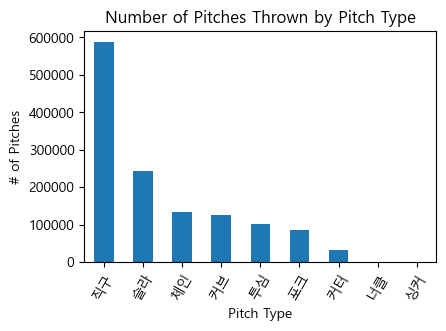

In [12]:
#plot the number of different pitch types that were thrown

_ = plt.figure(figsize=(10,3))
_ = plt.subplot(1,2,1)
_ = df['pitch_type'].value_counts().plot.bar()
_ = plt.title('Number of Pitches Thrown by Pitch Type', size='large')
_ = plt.xlabel('Pitch Type')
_ = plt.ylabel('# of Pitches')
_ = plt.ticklabel_format(style='plain', axis='y')
_ = plt.xticks(rotation=60)

In [13]:
df['pitch_class'].value_counts()

패스트볼    688325
슬라커터    274215
체포스플    219634
커브구종    125151
너클제외      1219
Name: pitch_class, dtype: int64

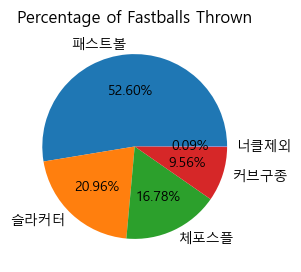

In [14]:
#find percentage of fastball vs offspeed
_ = plt.figure(figsize=(10,3))
_ = plt.subplot(1,2,2)
_ = df['pitch_class'].value_counts().plot.pie(labels=['패스트볼', '슬라커터', '체포스플', '커브구종', '너클제외'], autopct='%.2f%%')
_ = plt.title('Percentage of Fastballs Thrown', size='large')
_ = plt.ylabel(None)

#### Runners on base

In [15]:
#Split into smaller dataframes base on how many runners on on base 
no_runners = df[(df['1b'] == 0) & (df['2b'] == 0) & (df['3b'] == 0)]
on_1b = df[(df['1b'] == 1) & (df['2b'] == 0) & (df['3b'] == 0)]
on_2b = df[(df['1b'] == 0) & (df['2b'] == 1) & (df['3b'] == 0)]
on_3b = df[(df['1b'] == 0) & (df['2b'] == 0) & (df['3b'] == 1)]
on_1b2b = df[(df['1b'] == 1) & (df['2b'] == 1) & (df['3b'] == 0)]
on_1b3b = df[(df['1b'] == 1) & (df['2b'] == 0) & (df['3b'] == 1)]
on_2b3b = df[(df['1b'] == 0) & (df['2b'] == 1) & (df['3b'] == 1)]
bases_loaded = df[(df['1b'] == 1) & (df['2b'] == 1) & (df['3b'] == 1)]

In [16]:
# Calculating the fastball percentage for every on base scenario
runners_list = [no_runners, on_1b, on_2b, on_3b, on_1b2b, on_1b3b, on_2b3b, bases_loaded]
runners_data = []
for i in range(len(runners_list)):
    runners_data.append(np.sum(runners_list[i]['fastball']) / len(runners_list[i]))

runners_data

[0.5388810613476972,
 0.5343892611214975,
 0.47838283665385867,
 0.5066427873656789,
 0.4938031456677597,
 0.4962109107509701,
 0.48351218818847275,
 0.5326036157914156]

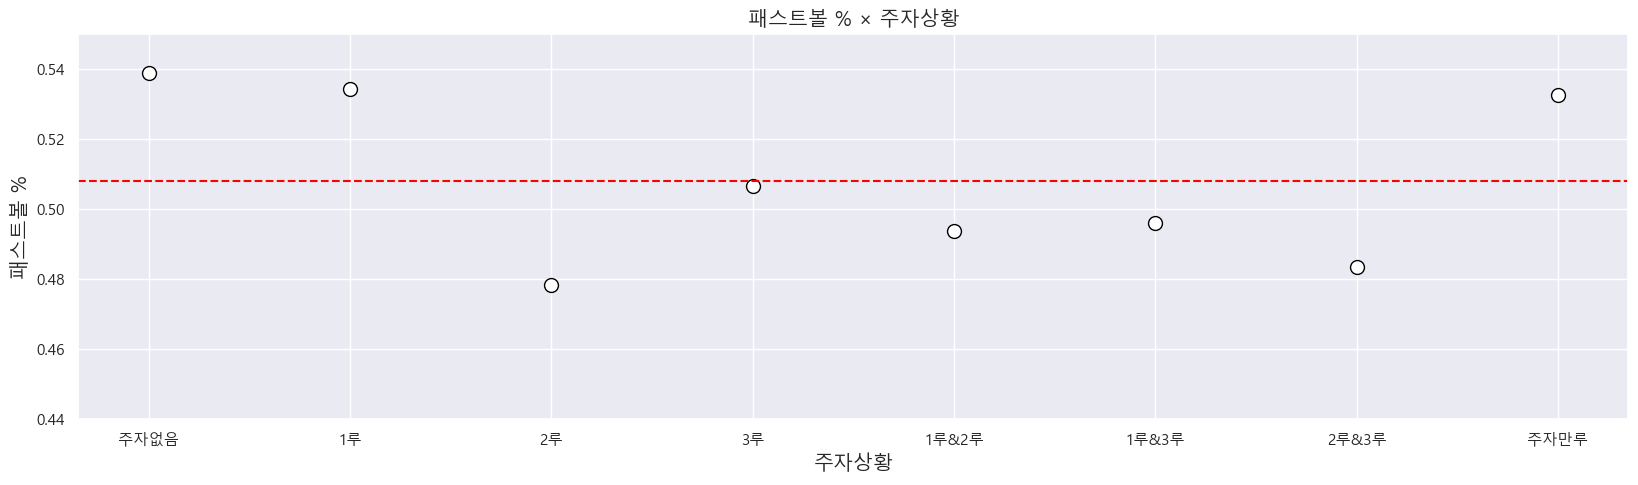

In [17]:
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False})
_ = plt.figure(figsize=(20,5))
_ = plt.plot(np.arange(len(runners_data)), runners_data, marker='o', linestyle='none', ms=10, mfc='white', mec='black')
_ = plt.title('패스트볼 % × 주자상황', size='large')
_ = plt.xlabel('주자상황', size='large')
_ = plt.ylabel('패스트볼 %', size='large')
_ = plt.xticks(np.arange(len(runners_data)), ['주자없음', '1루', '2루', '3루', '1루&2루', '1루&3루', '2루&3루', '주자만루'], rotation=0)
_ = plt.axhline(np.mean(runners_data), color='red', linestyle='--')
_ = plt.ylim((.44, .55))

#### Batting Count

In [18]:
count_0_0 = df[(df['b'] == 0) & (df['s'] == 0)]
count_0_1 = df[(df['b'] == 0) & (df['s'] == 1)]
count_0_2 = df[(df['b'] == 0) & (df['s'] == 2)]
count_1_0 = df[(df['b'] == 1) & (df['s'] == 0)]
count_1_1 = df[(df['b'] == 1) & (df['s'] == 1)]
count_1_2 = df[(df['b'] == 1) & (df['s'] == 2)]
count_2_0 = df[(df['b'] == 2) & (df['s'] == 0)]
count_2_1 = df[(df['b'] == 2) & (df['s'] == 1)]
count_2_2 = df[(df['b'] == 2) & (df['s'] == 2)]
count_3_0 = df[(df['b'] == 3) & (df['s'] == 0)]
count_3_1 = df[(df['b'] == 3) & (df['s'] == 1)]
count_3_2 = df[(df['b'] == 3) & (df['s'] == 2)]

# Calculating the fastball percentage for every scenario
count_list = [count_0_0, count_0_1, count_0_2, 
              count_1_0, count_1_1, count_1_2, 
              count_2_0, count_2_1, count_2_2, 
              count_3_0, count_3_1, count_3_2]
count_data = []
for i in range(len(count_list)):
    count_data.append(np.sum(count_list[i]['fastball']) / len(count_list[i]))

count_data

[0.5598386824749162,
 0.46489214109442717,
 0.4616198780303412,
 0.5660424746075715,
 0.46838520677502343,
 0.42812872467222884,
 0.6953359376686163,
 0.5768811804150692,
 0.45503726296741936,
 0.9196375421654871,
 0.7392063230693232,
 0.5584993877323834]

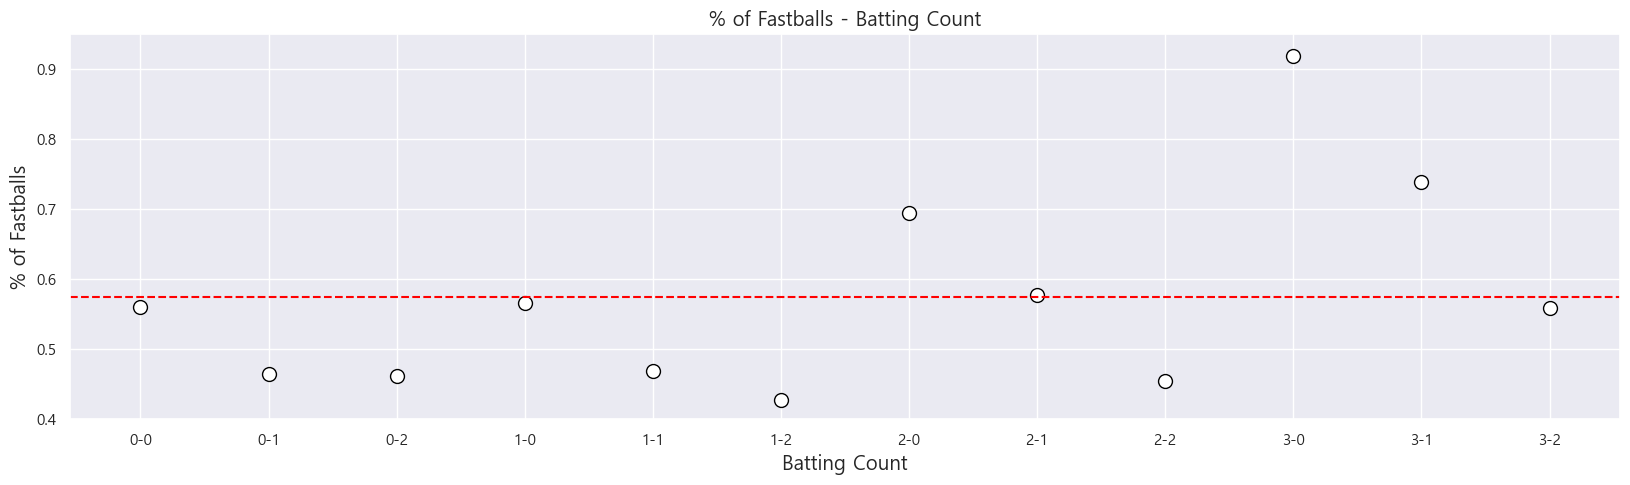

In [19]:
# Graphing the results
_ = plt.figure(figsize=(20,5))
_ = plt.plot(np.arange(len(count_data)), count_data, marker='o', linestyle='none', ms=10, mfc='white', mec='black')
_ = plt.title('% of Fastballs - Batting Count', size='large')
_ = plt.xlabel('Batting Count', size='large')
_ = plt.ylabel('% of Fastballs', size='large')
_ = plt.xticks(np.arange(len(count_data)), ['0-0', '0-1', '0-2', '1-0', '1-1', '1-2', '2-0', '2-1', '2-2', '3-0', '3-1', '3-2'], rotation=0)
_ = plt.axhline(np.mean(count_data), color='red', linestyle='--')
_ = plt.ylim((.40, .95))

#### Number of Pitches Thrown

In [20]:
pitch1 = df[df['pitch_number'] == 1]
pitch2 = df[df['pitch_number'] == 2]
pitch3 = df[df['pitch_number'] == 3]
pitch4 = df[df['pitch_number'] == 4]
pitch5 = df[df['pitch_number'] == 5]
pitch6 = df[df['pitch_number'] == 6]
pitchover = df[df['pitch_number'] > 6]

# Calculating the fastball percentage for each pitch
pitch_list = [pitch1, pitch2, pitch3, pitch4, pitch5, pitch6, pitchover]
pitch_data = []
for i in range(len(pitch_list)):
    pitch_data.append(np.sum(pitch_list[i]['fastball']) / len(pitch_list[i]))

pitch_data

[0.5598299448533762,
 0.5107563284350531,
 0.5125795769743032,
 0.5264332788134194,
 0.519001897777349,
 0.49814032373244466,
 0.5070235383447228]

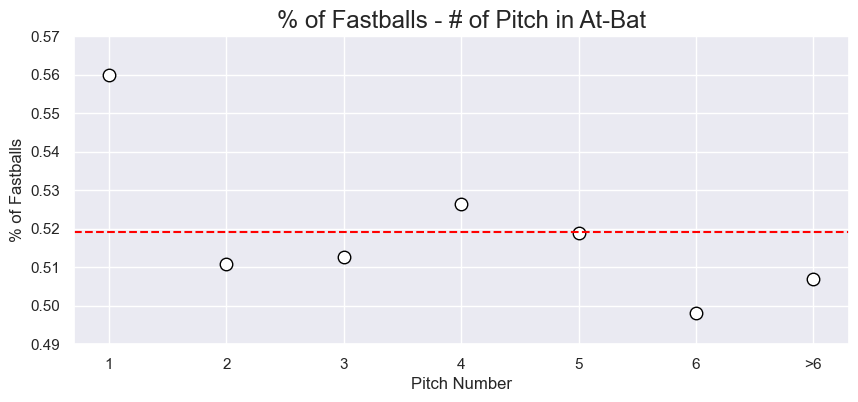

In [21]:
# Graphing the results
_ = sns.set()
_ = plt.figure(figsize=(10,4))
_ = plt.plot(np.arange(len(pitch_data)), pitch_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - # of Pitch in At-Bat', size='x-large')
_ = plt.xlabel('Pitch Number')
_ = plt.ylabel('% of Fastballs')
_ = plt.xticks(np.arange(len(pitch_data)), ['1', '2', '3', '4', '5', '6', '>6'])
_ = plt.axhline(np.mean(pitch_data), color='red', linestyle='--')
_ = plt.ylim((.49, .57))

#### Fastballs by Inning 

In [22]:
# Dividing the data by inning
first_inn = df[df['inning'] == 1]
second_inn = df[df['inning'] == 2]
third_inn = df[df['inning'] == 3]
fourth_inn = df[df['inning'] == 4]
fifth_inn = df[df['inning'] == 5]
sixth_inn = df[df['inning'] == 6]
seventh_inn = df[df['inning'] == 7]
eighth_inn = df[df['inning'] == 8]
ninth_inn = df[df['inning'] == 9]
extra_inn = df[df['inning'] > 9]

# Calculating the fastball percentage for each inning
inning_list = [first_inn, second_inn, third_inn, 
               fourth_inn, fifth_inn, sixth_inn, 
               seventh_inn, eighth_inn, ninth_inn, extra_inn]
inning_data = []
for i in range(len(inning_list)):
    inning_data.append(np.sum(inning_list[i]['fastball']) / len(inning_list[i]))

inning_data

[0.5676397410345592,
 0.5142813807747727,
 0.4960541535765864,
 0.484083597977955,
 0.4890458633403398,
 0.5014907857839759,
 0.536160693228756,
 0.5648995870301879,
 0.5893611866368751,
 0.5500331345261763]

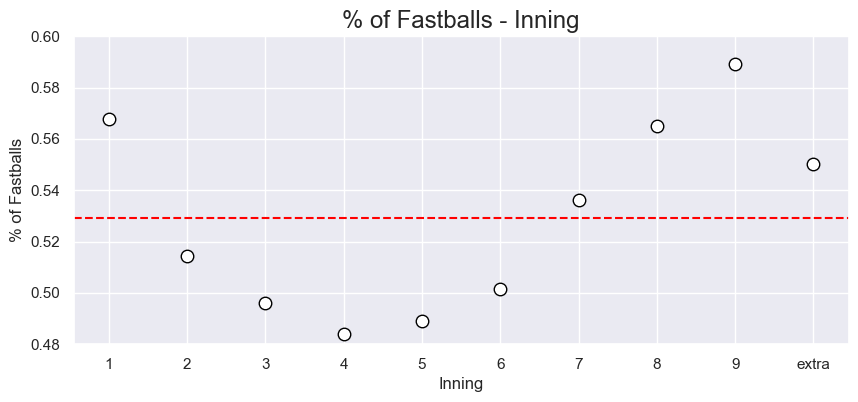

In [23]:
# Graphing the results
_ = plt.figure(figsize=(10,4))
_ = plt.plot(np.arange(len(inning_data)), inning_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - Inning', size='x-large')
_ = plt.xlabel('Inning')
_ = plt.ylabel('% of Fastballs')
_ = plt.xticks(np.arange(len(inning_data)), ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'extra'])
_ = plt.axhline(np.mean(inning_data), color='red', linestyle='--')
_ = plt.ylim((.48, .60))

#### Dominant hand Pitcher vs Batter

In [24]:
# Dividing the data based on pitcher and batter handedness
RvR = df[(df['throws'] == '우') & (df['stands'] == '우')]
LvR = df[(df['throws'] == '좌') & (df['stands'] == '우')]
RvL = df[(df['throws'] == '우') & (df['stands'] == '좌')]
LvL = df[(df['throws'] == '좌') & (df['stands'] == '좌')]

# Calculate the fastball percentage for each circumstance
PvB_list = [RvR, LvR, RvL, LvL]
PvB_data = []

for i in range(len(PvB_list)):
    PvB_data.append(np.sum(PvB_list[i]['fastball']) / len(PvB_list[i]))

PvB_data

[0.5149901802044916,
 0.5272937826696698,
 0.5343052809151948,
 0.5399820305480683]

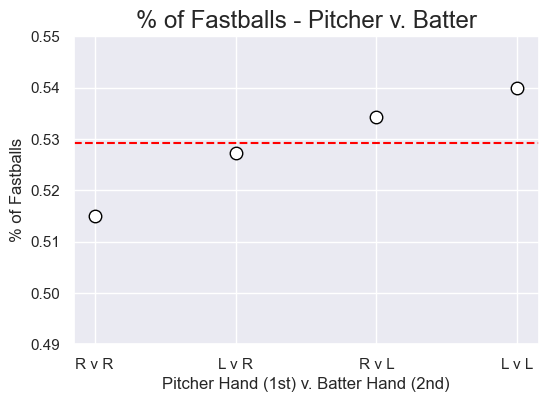

In [25]:
# Graphing the results
_ = plt.figure(figsize=(6,4))
_ = plt.plot(np.arange(len(PvB_data)), PvB_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - Pitcher v. Batter', size='x-large')
_ = plt.xlabel('Pitcher Hand (1st) v. Batter Hand (2nd)')
_ = plt.ylabel('% of Fastballs')
_ = plt.xticks(np.arange(len(PvB_data)), ['R v R', 'L v R', 'R v L', 'L v L'])
_ = plt.axhline(np.mean(PvB_data), color='red', linestyle='--')
_ = plt.ylim((.49, .55))

#### Number of Outs

In [26]:
df['o']

0          0
1          0
2          1
3          1
4          1
          ..
1308539    2
1308540    2
1308541    2
1308542    2
1308543    2
Name: o, Length: 1308544, dtype: int64

In [27]:
# Dividing the data based on number of outs
no_outs = df[df['o'] == 0]
one_outs = df[df['o'] == 1]
two_outs = df[df['o'] == 2]

# Calculating the fastball percentages for every scenario
outs_list = [no_outs, one_outs, two_outs]
outs_data = []
for i in range(len(outs_list)):
    outs_data.append(np.sum(outs_list[i]['fastball']) / len(outs_list[i]))
    
outs_data

[0.5560675540646635, 0.5173468028317185, 0.5032082817450416]

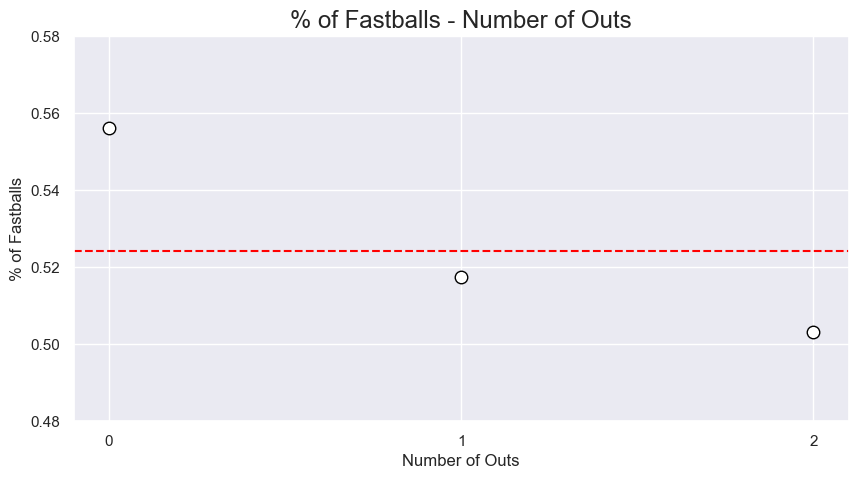

In [28]:
_ = plt.figure(figsize=(10,5))
_ = plt.plot(np.arange(len(outs_data)), outs_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - Number of Outs', size='x-large')
_ = plt.xlabel('Number of Outs')
_ = plt.ylabel('% of Fastballs')
_ = plt.xticks(np.arange(len(outs_data)), ['0', '1', '2'])
_ = plt.axhline(.5241, color='red', linestyle='--')
_ = plt.ylim((.48, .58))

#### Fastball based on Score

In [29]:
# Dividing the data based on game score
tie = df[(df['p_score'] - df['b_score']) == 0]
pitcher1 = df[(df['p_score'] - df['b_score']) == 1]
pitcher2 = df[(df['p_score'] - df['b_score']) == 2]
pitcher3 = df[(df['p_score'] - df['b_score']) == 3]
pitcher4 = df[(df['p_score'] - df['b_score']) == 4]
pitcher5 = df[(df['p_score'] - df['b_score']) == 5]
pitcher6 = df[(df['p_score'] - df['b_score']) == 6]
pitcher7 = df[(df['p_score'] - df['b_score']) == 7]
pitcher8 = df[(df['p_score'] - df['b_score']) == 8]
pitcherplus = df[(df['p_score'] - df['b_score']) > 8]
batter1 = df[(df['b_score'] - df['p_score']) == 1]
batter2 = df[(df['b_score'] - df['p_score']) == 2]
batter3 = df[(df['b_score'] - df['p_score']) == 3]
batter4 = df[(df['b_score'] - df['p_score']) == 4]
batter5 = df[(df['b_score'] - df['p_score']) == 5]
batter6 = df[(df['b_score'] - df['p_score']) == 6]
batter7 = df[(df['b_score'] - df['p_score']) == 7]
batter8 = df[(df['b_score'] - df['p_score']) == 8]
batterplus = df[(df['b_score'] - df['p_score']) > 8]

# Calculating the fastball percentage for each score
score_list = [pitcherplus, pitcher8, pitcher7, 
              pitcher6, pitcher5, pitcher4, 
              pitcher3, pitcher2, pitcher1, 
              tie, batter1, batter2, batter3,
              batter4, batter5, batter6, batter7, 
              batter8, batterplus]
score_data = []
for i in range(len(score_list)):
    score_data.append(np.sum(score_list[i]['fastball']) / len(score_list[i]))

    
score_data

[0.5859167211685198,
 0.5696557586060349,
 0.5655489453758789,
 0.5474356565846328,
 0.5406581302492083,
 0.5312949295504649,
 0.5300764813295578,
 0.5224058162590879,
 0.5124831150328291,
 0.5321965263442707,
 0.4983556739655316,
 0.5022099932675702,
 0.5153985259062389,
 0.5251661541513739,
 0.5402824858757063,
 0.5502672140035628,
 0.5620818686925956,
 0.5719752186588921,
 0.5752655180552277]

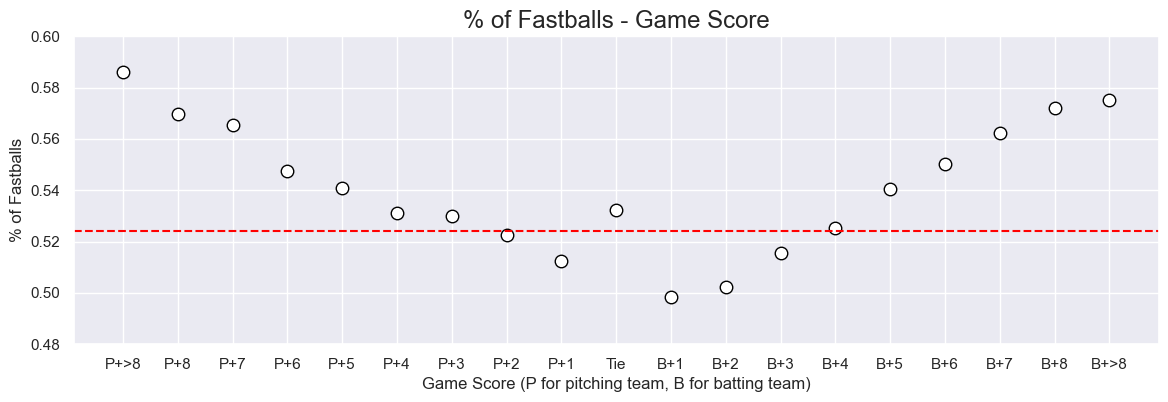

In [30]:
_ = plt.figure(figsize=(14,4))
_ = plt.plot(np.arange(len(score_data)), score_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - Game Score', size='x-large')
_ = plt.xlabel('Game Score (P for pitching team, B for batting team)')
_ = plt.ylabel('% of Fastballs')
_ = plt.xticks(np.arange(len(score_data)), ['P+>8', 'P+8', 'P+7', 'P+6', 'P+5', 'P+4', 'P+3', 'P+2', 'P+1', 'Tie', 'B+1', 'B+2', 'B+3', 'B+4', 'B+5', 'B+6', 'B+7', 'B+8', 'B+>8'])
_ = plt.axhline(.5241, color='red', linestyle='--')
_ = plt.ylim((.48, .60))

# 2. CONTINUOUS CATEGORIES

In [31]:
# functions for easier analysis
def ecdf(data):
    x=np.sort(data)
    y=np.arange(1, len(x) + 1) / len(x)
    return x, y

def graph_ecdf(variable, x_label, graph_title):
    _ = plt.xlabel('{}'.format(x_label))
    _ = plt.ylabel('ECDF')
    _ = plt.title('{}'.format(graph_title), size='large')

    x_fast, y_fast = ecdf(fastball['{}'.format(variable)])
    _ = plt.plot(x_fast, y_fast, marker='.', linestyle='none', label='fastballs')

    x_nofast, y_nofast = ecdf(nonfastball['{}'.format(variable)])
    _ = plt.plot(x_nofast, y_nofast, marker='.', linestyle='none', label='non-fastballs')

    _ = plt.legend()

def calculate_stats(df_fastball, df_nofastball):
    df_fastball_mean = np.mean(df_fastball)
    df_fastball_median = np.nanmedian(df_fastball)
    df_fastball_std = np.std(df_fastball)
    print("fastballs mean = {}".format(df_fastball_mean))
    print('fastballs median = {}'.format(df_fastball_median))
    print('fastballs std = {}'.format(df_fastball_std))

    df_nofastball_mean = np.mean(df_nofastball)
    df_nofastball_median = np.nanmedian(df_nofastball)
    df_nofastball_std = np.std(df_nofastball)
    print("non-fastballs mean = {}".format(df_nofastball_mean))
    print('non-fastballs median = {}'.format(df_nofastball_median))
    print('non-fastballs std = {}'.format(df_nofastball_std))



#### Starting Speed

<Figure size 1400x400 with 0 Axes>

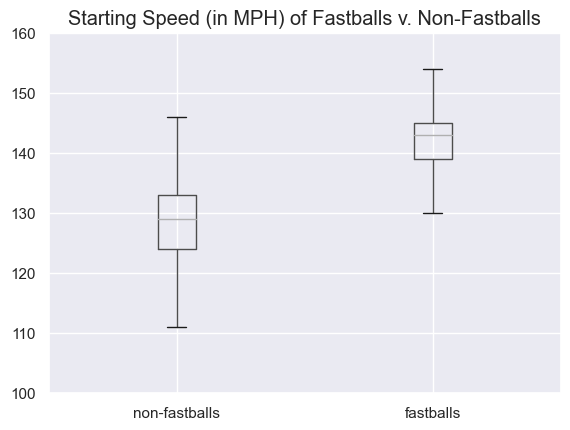

In [32]:
_ = plt.figure(figsize=(14,4))
_ = df[['fastball', 'speed']].boxplot(by = 'fastball', showfliers=False).set_xticklabels(['non-fastballs', 'fastballs'])
_ = plt.title('Starting Speed (in MPH) of Fastballs v. Non-Fastballs', size='large')
_ = plt.xlabel(None)
_ = plt.ylabel(None)
_ = plt.suptitle(None)
_ = plt.ylim((100, 160))

In [33]:
calculate_stats(fastball['speed'], nonfastball['speed'])

fastballs mean = 142.19593941815276
fastballs median = 143.0
fastballs std = 4.967832112820572
non-fastballs mean = 128.0298781559417
non-fastballs median = 129.0
non-fastballs std = 7.371914416973946


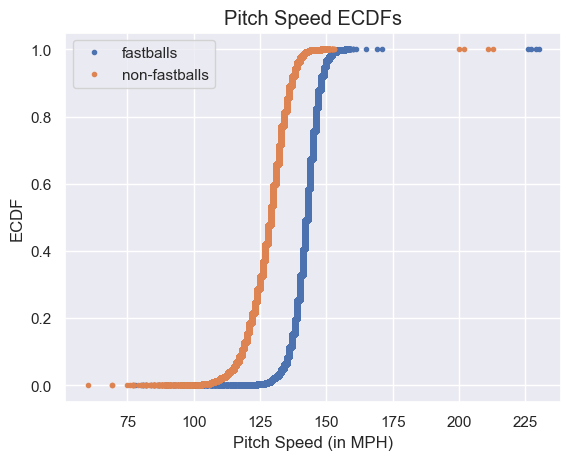

In [34]:
# Comparing the Empirical Cumulative Distribution Function (ECDF) for each of the datasets
graph_ecdf('speed', 'Pitch Speed (in MPH)', 'Pitch Speed ECDFs')

#### px Location

<Figure size 1400x400 with 0 Axes>

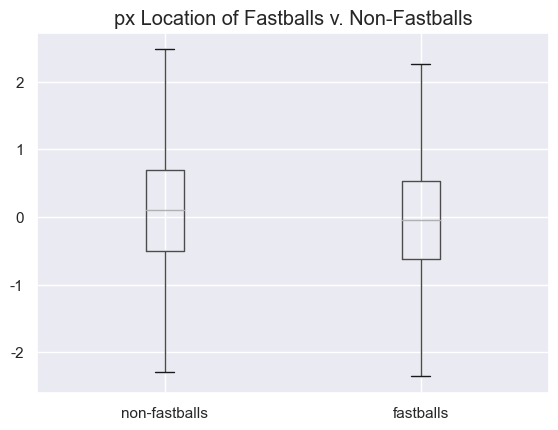

In [61]:
_ = sns.set()
_ = plt.figure(figsize=(14,4))
_ = df[['fastball', 'px']].boxplot(by = 'fastball', showfliers=False).set_xticklabels(['non-fastballs', 'fastballs'])
_ = plt.title('px Location of Fastballs v. Non-Fastballs', size='large')
_ = plt.xlabel(None)
_ = plt.ylabel(None)
_ = plt.suptitle(None)

In [36]:
# Calculating mean/median/std of each dataset
calculate_stats(fastball['px'], nonfastball['px'])

fastballs mean = -0.048261736550527505
fastballs median = -0.048
fastballs std = 0.8668739552669159
non-fastballs mean = 0.09392154330480962
non-fastballs median = 0.103
non-fastballs std = 0.8973004375198601


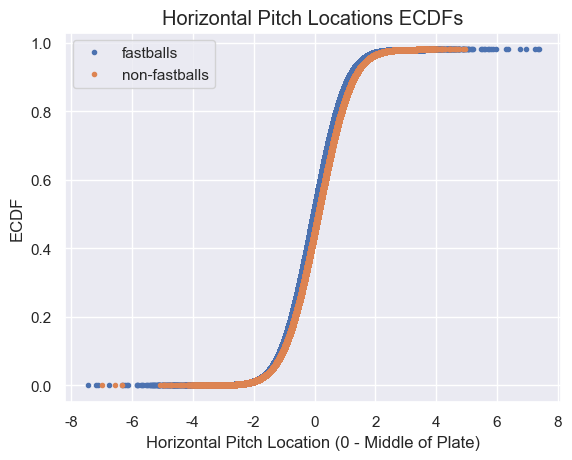

In [37]:
# Comparing the Empirical Cumulative Distribution Function (ECDF) for each of the datasets
graph_ecdf('px', 'Horizontal Pitch Location (0 - Middle of Plate)', 'Horizontal Pitch Locations ECDFs')

#### Vertical Location

<Figure size 1400x400 with 0 Axes>

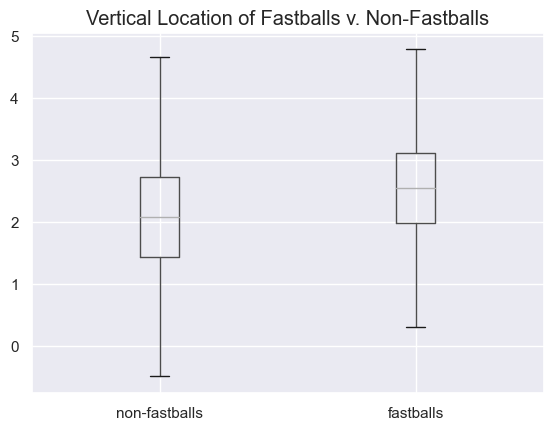

In [38]:
_ = plt.figure(figsize=(14,4))
_ = df[['fastball', 'pz']].boxplot(by = 'fastball', showfliers=False).set_xticklabels(['non-fastballs', 'fastballs'])
_ = plt.title('Vertical Location of Fastballs v. Non-Fastballs', size='large')
_ = plt.xlabel(None)
_ = plt.ylabel(None)
_ = plt.suptitle(None)

In [39]:
# Calculating mean/median/std of each dataset
calculate_stats(fastball['pz'], nonfastball['pz'])

fastballs mean = 2.562143753682707
fastballs median = 2.543
fastballs std = 0.8646527681849964
non-fastballs mean = 2.091166584513059
non-fastballs median = 2.088
non-fastballs std = 1.0044937328490808


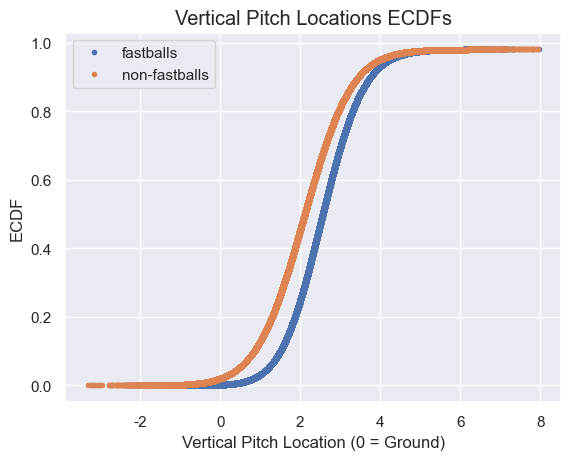

In [40]:
# Comparing the Empirical Cumulative Distribution Function (ECDF) for each of the datasets
graph_ecdf('pz', 'Vertical Pitch Location (0 = Ground)', 'Vertical Pitch Locations ECDFs')

# 4.PRE-PROCESSING

In [70]:
df_model = df.loc[:, ['gid-intot-panum', 'fastball', '1b', '2b', '3b']]

df_model.head(10)

,gid-intot-panum,fastball,1b,2b,3b
0,20170331HHOB02017-011-01,1,0,0,0
1,20170331HHOB02017-011-02,1,1,0,0
2,20170331HHOB02017-011-03,1,0,1,0
3,20170331HHOB02017-011-03,1,0,1,0
4,20170331HHOB02017-011-03,1,0,1,0
5,20170331HHOB02017-011-03,1,0,1,0
6,20170331HHOB02017-011-03,1,0,1,0
7,20170331HHOB02017-011-04,0,1,1,0
8,20170331HHOB02017-011-04,0,1,1,0
9,20170331HHOB02017-011-04,0,1,1,0


#### Binary  Features

In [71]:
df_model['p_throws_num'] = np.where(df.loc[:, 'throws'] == '우', 1, 0)
df_model['stand_num'] = np.where(df.loc[:, 'stands'] == '우', 1, 0)
df_model['top_num'] = np.where(df.loc[:, 'inning_topbot'] == '초', 1, 0)

df_model.head()

,gid-intot-panum,fastball,1b,2b,3b,p_throws_num,stand_num,top_num
0,20170331HHOB02017-011-01,1,0,0,0,1,1,1
1,20170331HHOB02017-011-02,1,1,0,0,1,0,1
2,20170331HHOB02017-011-03,1,0,1,0,1,1,1
3,20170331HHOB02017-011-03,1,0,1,0,1,1,1
4,20170331HHOB02017-011-03,1,0,1,0,1,1,1


### Pitch Number

In [72]:
df['pitch_number'] = df['pitch_number'].replace([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 10)
df_dummies = pd.get_dummies(df['pitch_number'], prefix='pitch_number', drop_first=True)
df_model = pd.concat([df_model, df_dummies], axis=1)
df_model.head(10)

,gid-intot-panum,fastball,1b,2b,3b,p_throws_num,stand_num,top_num,pitch_number_2,pitch_number_3,pitch_number_4,pitch_number_5,pitch_number_6,pitch_number_7,pitch_number_8,pitch_number_9,pitch_number_10
0,20170331HHOB02017-011-01,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
1,20170331HHOB02017-011-02,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
3,20170331HHOB02017-011-03,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0
4,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0
5,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0
6,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0
7,20170331HHOB02017-011-04,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0
8,20170331HHOB02017-011-04,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0
9,20170331HHOB02017-011-04,0,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0


#### Batting Count - Balls
The values in this column should range from 0-3, but we have a few values of 4. I will convert those to 3.

In [73]:
df['b'].value_counts()

0    580229
1    395719
2    224231
3    108365
Name: b, dtype: int64

In [74]:
df['b'] = df['b'].replace(4, 3)
df_dummies = pd.get_dummies(df['b'], prefix='b', drop_first=True)
df_model = pd.concat([df_model, df_dummies], axis=1)
df_model.head(10)

,gid-intot-panum,fastball,1b,2b,3b,p_throws_num,stand_num,top_num,pitch_number_2,pitch_number_3,pitch_number_4,pitch_number_5,pitch_number_6,pitch_number_7,pitch_number_8,pitch_number_9,pitch_number_10,b_1,b_2,b_3
0,20170331HHOB02017-011-01,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,20170331HHOB02017-011-02,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,20170331HHOB02017-011-03,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0
4,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0
5,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0
6,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1
7,20170331HHOB02017-011-04,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
8,20170331HHOB02017-011-04,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
9,20170331HHOB02017-011-04,0,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0


#### Batting Count - Strikes and Outs
Both of these features need no manipluation. Add them to the model dataframe.

In [75]:
# Create the dummy variables
df_dummies = pd.get_dummies(df['s'], prefix='s', drop_first=True)

# Add the dummy variables to the model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

In [76]:
df_dummies = pd.get_dummies(df['o'], prefix='o', drop_first=True)
df_model = pd.concat([df_model, df_dummies], axis=1)

#### Inning
Similar to the at-bat pitch count, the inning variable has a few outliers for games that went deep into extra innings. 
For the purpose of analysis, I will group all extra inning games together and add them to the model dataframe.

In [77]:
df['inning'].value_counts()

1     153534
8     148437
7     148407
6     146567
3     146103
4     145793
5     145105
2     145049
9     111441
10     18108
Name: inning, dtype: int64

In [78]:
# Combine all extra inning games into one column
df['inning'] = df['inning'].replace([11, 12, 13, 14, 15, 16, 17, 18, 19], 10)

# Create the dummy variables
df_dummies = pd.get_dummies(df['inning'], prefix='inning', drop_first=True)

# Add the dummy variables to the model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

#### Pitcher Score and Batter Score

These two features provide the current score for each team for each pitch. The most efficient way to incorporate this data is to create a new column that provides the difference between the teams' scores. 

The outlier scores will also be combined into one column for any spread of 10 or more runs. 

In [79]:
# Create the new difference in score column
df['pitcher_lead'] = df['p_score'] - df['b_score']

# Combine the outlier score differences
df['pitcher_lead'] = df['pitcher_lead'].replace([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24], 10)
df['pitcher_lead'] = df['pitcher_lead'].replace([-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -23, -24], -10)

# Create the dummy variables
df_dummies = pd.get_dummies(df['pitcher_lead'], prefix='pitcher_lead', drop_first=True)

# Add the dummy variables to the model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

In [80]:
df_model.head(10)

,gid-intot-panum,fastball,1b,2b,3b,p_throws_num,stand_num,top_num,pitch_number_2,pitch_number_3,...,pitcher_lead_2,pitcher_lead_3,pitcher_lead_4,pitcher_lead_5,pitcher_lead_6,pitcher_lead_7,pitcher_lead_8,pitcher_lead_9,pitcher_lead_10,pitcher_lead_22
0,20170331HHOB02017-011-01,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20170331HHOB02017-011-02,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20170331HHOB02017-011-03,1,0,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,20170331HHOB02017-011-03,1,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,20170331HHOB02017-011-04,0,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,20170331HHOB02017-011-04,0,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9,20170331HHOB02017-011-04,0,1,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [81]:
df_model.shape

(1308544, 56)

# MODELING

### Test Run Model

I will use a sample of 400,000 pitches.(30% of 1,308,544)

In [114]:
df_model=df_model[~(df_model['gid-intot-panum'].str.contains('2017')|df_model['gid-intot-panum'].str.contains('2018')|df_model['gid-intot-panum'].str.contains('2019'))].reset_index(drop=True)

In [134]:
df20=df[~(df['gid-intot-panum'].str.contains('2017')|df['gid-intot-panum'].str.contains('2018')|df['gid-intot-panum'].str.contains('2019'))].reset_index(drop=True)

In [133]:
# create the sample dataframe
df_sample = df_model.sample(10000, random_state=0)

df_sample.columns

Index(['gid-intot-panum', 'fastball', '1b', '2b', '3b', 'p_throws_num',
       'stand_num', 'top_num', 'pitch_number_2', 'pitch_number_3',
       'pitch_number_4', 'pitch_number_5', 'pitch_number_6', 'pitch_number_7',
       'pitch_number_8', 'pitch_number_9', 'pitch_number_10', 'b_1', 'b_2',
       'b_3', 's_1', 's_2', 'o_1', 'o_2', 'inning_2', 'inning_3', 'inning_4',
       'inning_5', 'inning_6', 'inning_7', 'inning_8', 'inning_9', 'inning_10',
       'pitcher_lead_-21', 'pitcher_lead_-10', 'pitcher_lead_-9',
       'pitcher_lead_-8', 'pitcher_lead_-7', 'pitcher_lead_-6',
       'pitcher_lead_-5', 'pitcher_lead_-4', 'pitcher_lead_-3',
       'pitcher_lead_-2', 'pitcher_lead_-1', 'pitcher_lead_0',
       'pitcher_lead_1', 'pitcher_lead_2', 'pitcher_lead_3', 'pitcher_lead_4',
       'pitcher_lead_5', 'pitcher_lead_6', 'pitcher_lead_7', 'pitcher_lead_8',
       'pitcher_lead_9', 'pitcher_lead_10', 'pitcher_lead_22'],
      dtype='object')

In [119]:
# verify the fastball/non-fastball split
df_sample['fastball'].sum() / len(df_sample)

0.520745

In [120]:
# split the dataframe
X = df_sample.iloc[:, 2:]
y = df_sample.iloc[:, 1]

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [122]:
len(X_test)

50000

#### Logistic Regression

In [123]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('Training Set Accuracy: {}'.format(lr.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(lr.score(X_test, y_test)))

Training Set Accuracy: 0.5799933333333334
Test Set Accuracy: 0.58092


#### SGDClassifier

In [124]:
sgdc = SGDClassifier()
sgdc.fit(X_train, y_train)
y_pred_sgdc = sgdc.predict(X_test)
print('Training Set Accuracy: {}'.format(sgdc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(sgdc.score(X_test, y_test)))

Training Set Accuracy: 0.5682933333333333
Test Set Accuracy: 0.56964


#### Random Forest Classifier

In [125]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print('Training Set Accuracy: {}'.format(rfc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(rfc.score(X_test, y_test)))

Training Set Accuracy: 0.8004133333333333
Test Set Accuracy: 0.55218


#### Gradient Boosting Classifier

In [126]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
print('Training Set Accuracy: {}'.format(gbc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(gbc.score(X_test, y_test)))

Training Set Accuracy: 0.5845733333333333
Test Set Accuracy: 0.58402


### Adding Previous Pitch Features

#### Previous Pitch Type/Location

In [135]:
df20.shape

(658815, 198)

In [136]:
# create a new dataframe to build the new features
df_prev_pitch = df20.loc[:9999, ['pitch_number', 'pitch_type', 'px', 'pz']]

# shift the pitch_type, px, and pz columns down one row
df_prev_pitch['pitch_type'] = df_prev_pitch['pitch_type'].shift(1, axis=0)
df_prev_pitch['px'] = df_prev_pitch['px'].shift(1, axis=0)
df_prev_pitch['pz'] = df_prev_pitch['pz'].shift(1, axis=0)

# add the new feature columns
df_prev_pitch['pitch_type_prev'] = 0
df_prev_pitch['px_prev'] = 0
df_prev_pitch['pz_prev'] = 0

df_prev_pitch.head()

,pitch_number,pitch_type,px,pz,pitch_type_prev,px_prev,pz_prev
0,1,None,NaN,NaN,0,0,0
1,2,직구,-0.268,1.629,0,0,0
2,3,직구,0.259,3.327,0,0,0
3,4,직구,-1.780,2.522,0,0,0
4,5,직구,-0.406,3.311,0,0,0


In [131]:
# build the function
def prev_pitch(df):
    
    for i  in range (10000):
            df[['pitch_type_prev', 'px_prev', 'pz_prev']] = df[['pitch_type', 'px', 'pz']].shift(1)
    return df

In [137]:
# run the function 
df_prev_pitch = prev_pitch(df_prev_pitch)

In [138]:
df_prev_pitch.shape

(10000, 7)

In [139]:
#add new feature to our dataframe 
df_sample.reset_index(drop=True, inplace=True)
df_prev_pitch.reset_index(drop=True, inplace=True)

df_sample = pd.concat([df_sample, df_prev_pitch], axis=1)
df_sample.head()

,gid-intot-panum,fastball,1b,2b,3b,p_throws_num,stand_num,top_num,pitch_number_2,pitch_number_3,...,pitcher_lead_9,pitcher_lead_10,pitcher_lead_22,pitch_number,pitch_type,px,pz,pitch_type_prev,px_prev,pz_prev
0,20210413LTHT02021-011-06,0,1,1,0,1,1,1,0,0,...,0,0,0,1,None,NaN,NaN,None,NaN,NaN
1,20200916LTWO02020-071-51,1,1,0,0,0,0,1,0,0,...,0,0,0,2,직구,-0.268,1.629,None,NaN,NaN
2,20210902KTWO02021-051-35,0,0,0,1,1,1,1,0,1,...,0,0,0,3,직구,0.259,3.327,직구,-0.268,1.629
3,20200526SKOB02020-061-38,1,0,0,0,1,1,1,0,0,...,0,0,0,4,직구,-1.780,2.522,직구,0.259,3.327
4,20211014SSHT02021-011-01,1,0,0,0,1,0,1,1,0,...,0,0,0,5,직구,-0.406,3.311,직구,-1.780,2.522


In [140]:
# replace the missing and zero values with NaNs
df_sample['px_prev'] = df_sample['px_prev'].replace(0.000000, np.nan)
df_sample['px_prev'] = df_sample['px_prev'].replace(0.006600, np.nan)

df_sample.loc[(df_sample['px_prev'] > 4), 'px_prev'] = 4
df_sample.loc[(df_sample['px_prev'] < -4), 'px_prev'] = -4

df_sample.head()

,gid-intot-panum,fastball,1b,2b,3b,p_throws_num,stand_num,top_num,pitch_number_2,pitch_number_3,...,pitcher_lead_9,pitcher_lead_10,pitcher_lead_22,pitch_number,pitch_type,px,pz,pitch_type_prev,px_prev,pz_prev
0,20210413LTHT02021-011-06,0,1,1,0,1,1,1,0,0,...,0,0,0,1,None,NaN,NaN,None,NaN,NaN
1,20200916LTWO02020-071-51,1,1,0,0,0,0,1,0,0,...,0,0,0,2,직구,-0.268,1.629,None,NaN,NaN
2,20210902KTWO02021-051-35,0,0,0,1,1,1,1,0,1,...,0,0,0,3,직구,0.259,3.327,직구,-0.268,1.629
3,20200526SKOB02020-061-38,1,0,0,0,1,1,1,0,0,...,0,0,0,4,직구,-1.780,2.522,직구,0.259,3.327
4,20211014SSHT02021-011-01,1,0,0,0,1,0,1,1,0,...,0,0,0,5,직구,-0.406,3.311,직구,-1.780,2.522


In [141]:
#check for any NaN values remaining
nan_values = df_sample.isna()
nan_columns = nan_values.any()

columns_with_nan = df_sample.columns[nan_columns].tolist()
print(columns_with_nan)

['pitch_type', 'px', 'pz', 'pitch_type_prev', 'px_prev', 'pz_prev']


In [142]:
#Create dict with values to replace 
values = {'pitch_type': 'UN', 'px': 0, 'pz': 0, 'pitch_type_prev': 'UN' ,'px_prev': 0, 'pz_prev': 0}
df_sample.replace(np.nan, values, inplace = True)

In [143]:
df_sample.head()

,gid-intot-panum,fastball,1b,2b,3b,p_throws_num,stand_num,top_num,pitch_number_2,pitch_number_3,...,pitcher_lead_9,pitcher_lead_10,pitcher_lead_22,pitch_number,pitch_type,px,pz,pitch_type_prev,px_prev,pz_prev
0,20210413LTHT02021-011-06,0,1,1,0,1,1,1,0,0,...,0,0,0,1,UN,0.000,0.000,UN,0.000,0.000
1,20200916LTWO02020-071-51,1,1,0,0,0,0,1,0,0,...,0,0,0,2,직구,-0.268,1.629,UN,0.000,0.000
2,20210902KTWO02021-051-35,0,0,0,1,1,1,1,0,1,...,0,0,0,3,직구,0.259,3.327,직구,-0.268,1.629
3,20200526SKOB02020-061-38,1,0,0,0,1,1,1,0,0,...,0,0,0,4,직구,-1.780,2.522,직구,0.259,3.327
4,20211014SSHT02021-011-01,1,0,0,0,1,0,1,1,0,...,0,0,0,5,직구,-0.406,3.311,직구,-1.780,2.522


In [144]:
# replace the missing and zero values with NaNs
df_prev_pitch['pz_prev'] = df_prev_pitch['pz_prev'].replace(0.000000, np.nan)
df_prev_pitch['pz_prev'] = df_prev_pitch['pz_prev'].replace(2.250000, np.nan)

df_sample.loc[(df_sample['pz_prev'] > 5), 'pz_prev'] = 5
df_sample.loc[(df_sample['pz_prev'] < -1), 'pz_prev'] = -1


In [154]:
# create a duplicate pitch type column
df_sample['prev_fastball'] = df_sample['pitch_type_prev']
df_sample['prev_fastball'] = df_sample['pitch_type_prev'].replace({'직구':'FF', '투심':'FF', '싱커':'FF'}, regex=True)
df_sample['prev_fastball'] = np.where(df_sample['prev_fastball'] == 'FF', 1, 0)

df_sample.head(10)

,gid-intot-panum,fastball,1b,2b,3b,p_throws_num,stand_num,top_num,pitch_number_2,pitch_number_3,...,pitcher_lead_10,pitcher_lead_22,pitch_number,pitch_type,px,pz,pitch_type_prev,px_prev,pz_prev,prev_fastball
0,20210413LTHT02021-011-06,0,1,1,0,1,1,1,0,0,...,0,0,1,UN,0.000,0.000,UN,0.000,0.000,0
1,20200916LTWO02020-071-51,1,1,0,0,0,0,1,0,0,...,0,0,2,직구,-0.268,1.629,UN,0.000,0.000,0
2,20210902KTWO02021-051-35,0,0,0,1,1,1,1,0,1,...,0,0,3,직구,0.259,3.327,직구,-0.268,1.629,1
3,20200526SKOB02020-061-38,1,0,0,0,1,1,1,0,0,...,0,0,4,직구,-1.780,2.522,직구,0.259,3.327,1
4,20211014SSHT02021-011-01,1,0,0,0,1,0,1,1,0,...,0,0,5,직구,-0.406,3.311,직구,-1.780,2.522,1
5,20200828KTLG02020-099-69,1,1,1,1,1,0,0,0,0,...,0,0,6,체인,-0.905,2.253,직구,-0.406,3.311,1
6,20200806KTWO02020-081-61,1,1,1,0,0,1,1,1,0,...,0,0,1,직구,0.217,2.136,체인,-0.905,2.253,0
7,20211002NCLT02021-049-31,1,0,0,0,1,1,0,0,0,...,0,0,2,직구,0.163,3.124,직구,0.217,2.136,1
8,20200918HTSS02020-011-04,0,1,0,0,1,0,1,0,0,...,0,0,3,커브,0.199,1.938,직구,0.163,3.124,1
9,20210506LGOB02021-021-14,0,1,1,1,0,0,1,0,0,...,0,0,4,슬라,-1.270,1.962,커브,0.199,1.938,0


In [156]:
#Drop non-numerical columns
df_sample.drop('pitch_type', axis = 1, inplace = True)
df_sample.drop('pitch_type_prev', axis = 1, inplace = True)
df_sample.drop('px', axis = 1, inplace = True)
df_sample.drop('pz', axis = 1, inplace = True)

In [157]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gid-intot-panum   10000 non-null  object 
 1   fastball          10000 non-null  int32  
 2   1b                10000 non-null  int64  
 3   2b                10000 non-null  int64  
 4   3b                10000 non-null  int64  
 5   p_throws_num      10000 non-null  int32  
 6   stand_num         10000 non-null  int32  
 7   top_num           10000 non-null  int32  
 8   pitch_number_2    10000 non-null  uint8  
 9   pitch_number_3    10000 non-null  uint8  
 10  pitch_number_4    10000 non-null  uint8  
 11  pitch_number_5    10000 non-null  uint8  
 12  pitch_number_6    10000 non-null  uint8  
 13  pitch_number_7    10000 non-null  uint8  
 14  pitch_number_8    10000 non-null  uint8  
 15  pitch_number_9    10000 non-null  uint8  
 16  pitch_number_10   10000 non-null  uint8  

In [158]:
# split the dataframe
X = df_sample.iloc[:, 2:]
y = df_sample.iloc[:, 1]

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

### SECOND ROUND OF MODELING WITH NEW FEATURES 

Now that I have added some previous pitch features, I will re-rerun the data through the default classifiers to see if the accuracy improves.



#### Logistic Regression

In [159]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('Training Set Accuracy: {}'.format(lr.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(lr.score(X_test, y_test)))

Training Set Accuracy: 0.5908
Test Set Accuracy: 0.58


#### SGDClassifier

In [160]:
sgdc = SGDClassifier()
sgdc.fit(X_train, y_train)
y_pred_sgdc = sgdc.predict(X_test)
print('Training Set Accuracy: {}'.format(sgdc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(sgdc.score(X_test, y_test)))

Training Set Accuracy: 0.5593333333333333
Test Set Accuracy: 0.5528


#### Random Forest Classifier

In [161]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print('Training Set Accuracy: {}'.format(rfc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(rfc.score(X_test, y_test)))

Training Set Accuracy: 1.0
Test Set Accuracy: 0.5632


#### Gradient Boosting Classifier

In [162]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
print('Training Set Accuracy: {}'.format(gbc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(gbc.score(X_test, y_test)))

Training Set Accuracy: 0.6356
Test Set Accuracy: 0.572


### THIRD ROUND OF MODELING USING GRIDCVSEARCH

GridSearchCV is used to optimize our classifier and iterate through different parameters to find the best model.

#### Logistic Regression

In [163]:
param_grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

g_search = GridSearchCV(estimator = lr, 
                        param_grid = param_grid, 
                        cv = 3, n_jobs = 1, 
                        verbose = 0, 
                        return_train_score=True
                       )

g_search.fit(X_train,y_train)

print(g_search.best_params_)

{'C': 1000.0, 'penalty': 'l2'}


In [164]:
lr1 = LogisticRegression(C = 0.01, penalty = 'l2')

lr1.fit(X_train, y_train)
pred_lr = lr1.predict(X_test)

print('Training Set Accuracy: {}'.format(lr1.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(lr1.score(X_test, y_test)))

Training Set Accuracy: 0.5805333333333333
Test Set Accuracy: 0.5688


#### SGDClassifier

In [165]:
param_grid = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"]}

g_search = GridSearchCV(estimator= sgdc, 
                        param_grid=param_grid,
                        cv = 3, n_jobs = 1, 
                        verbose = 0, 
                        return_train_score=True)

g_search.fit(X_train,y_train)

print(g_search.best_params_)

{'alpha': 0.001, 'loss': 'log', 'penalty': 'l1'}


In [167]:
sgdc1 = SGDClassifier(alpha = 0.1, loss = 'hinge', penalty = 'elasticnet')
sgdc1.fit(X_train, y_train)
pred_sgdc = sgdc1.predict(X_test)

print('Training Set Accuracy: {}'.format(sgdc1.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(sgdc1.score(X_test, y_test)))

Training Set Accuracy: 0.5254666666666666
Test Set Accuracy: 0.5256


#### Random Forest Classifier

In [168]:
param_grid = { 
    'n_estimators': [200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

g_search = GridSearchCV(estimator = rfc, 
                        param_grid = param_grid, 
                        cv = 3, n_jobs = 1, 
                        verbose = 0, 
                        return_train_score=True)

g_search.fit(X_train, y_train)
print(g_search.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 300}


In [169]:
rfc1 = RandomForestClassifier(random_state=42, 
                           max_features='sqrt', 
                           n_estimators= 200, 
                           max_depth=8,  
                           criterion='entropy')

rfc1.fit(X_train, y_train)
pred_rfc = rfc1.predict(X_test)

print('Training Set Accuracy: {}'.format(rfc1.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(rfc1.score(X_test, y_test)))
#print("Mean Squared Error: "  + str(metrics.mean_squared_error(y_test, pred)))

Training Set Accuracy: 0.6794666666666667
Test Set Accuracy: 0.5804


#### Gradient Boosting Classifier

In [171]:
param_grid = {
    "loss":["deviance"],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt", "auto"],
    "criterion": ["mse",  "mae", "squared_error"],
    "n_estimators": [10]
    }

g_search = GridSearchCV(estimator = gbc,
                        param_grid = param_grid, 
                        cv = 3, n_jobs = 1, 
                        verbose = 0, 
                        return_train_score=True)

g_search.fit(X_train, y_train)
print(g_search.best_params_)

{'criterion': 'squared_error', 'loss': 'deviance', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10}


In [173]:
gbc1 = GradientBoostingClassifier(random_state=42, 
                               criterion = 'squared_error', 
                               loss = 'deviance', 
                               max_depth = 3, 
                               max_features = 'sqrt',
                               min_samples_leaf = 0.1, 
                               min_samples_split = 0.1,
                               n_estimators = 10)

gbc1.fit(X_train, y_train)
pred_gbc = gbc1.predict(X_test)

print('Training Set Accuracy: {}'.format(gbc1.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(gbc1.score(X_test, y_test)))

Training Set Accuracy: 0.5312
Test Set Accuracy: 0.5268


### Classification Reports and Confusion Matrix 

In [174]:
# Classification report Logistic Regression
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.56      0.43      0.49      1186
           1       0.57      0.69      0.63      1314

    accuracy                           0.57      2500
   macro avg       0.57      0.56      0.56      2500
weighted avg       0.57      0.57      0.56      2500



In [175]:
#Confusion Matrix Logistic Regression
print(confusion_matrix(y_test, pred_lr))

[[510 676]
 [402 912]]


In [176]:
# Classification report Gradient Boosting
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_gbc))

              precision    recall  f1-score   support

           0       0.52      0.03      0.06      1186
           1       0.53      0.98      0.68      1314

    accuracy                           0.53      2500
   macro avg       0.52      0.50      0.37      2500
weighted avg       0.52      0.53      0.39      2500



In [177]:
# Confusion matrix Gradient Boosting
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred_gbc))

[[  35 1151]
 [  32 1282]]


In [178]:
# Classification report Random Forest
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.57      0.46      0.51      1186
           1       0.59      0.69      0.63      1314

    accuracy                           0.58      2500
   macro avg       0.58      0.57      0.57      2500
weighted avg       0.58      0.58      0.57      2500



In [179]:
# Confusion matrix Random Forest
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred_rfc))

[[545 641]
 [408 906]]


### FEATURE IMPORTANCE

In [180]:
df_features = pd.DataFrame(
    {'coefficient': lr.coef_.flatten(), 'rfc_feature_importance': rfc.feature_importances_}, 
    index=df_sample.columns[2:])

In [181]:
#top features
df_features.sort_values('rfc_feature_importance', ascending=False)[:15]

,coefficient,rfc_feature_importance
pz_prev,-0.022094,0.153677
px_prev,0.018483,0.152842
pitch_number,-0.006581,0.080411
stand_num,0.004341,0.030107
top_num,0.001968,0.030049
prev_fastball,-0.034361,0.029237
1b,0.028644,0.028674
p_throws_num,0.009942,0.024427
o_1,-0.069130,0.023586
pitcher_lead_0,-0.101763,0.021787


In [182]:
#Least important features
df_features.sort_values('coefficient')[:15]

,coefficient,rfc_feature_importance
s_2,-1.101481,0.015197
pitch_number_9,-0.773978,0.000972
s_1,-0.678565,0.013774
inning_4,-0.380818,0.012915
pitcher_lead_-9,-0.340973,0.002151
inning_2,-0.318191,0.013514
inning_5,-0.313301,0.012821
inning_6,-0.290980,0.014467
2b,-0.275601,0.017059
pitcher_lead_-4,-0.265228,0.007760
